<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px" style="display: inline-block; margin-top: 5px;">
<img src="http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png" width="150px" class="pull-right" style="display: inline-block; margin: 0px;">
</div>

# Welcome to Example Platform-library PySpark Notebook

It's a shared Jupyter server for you to learn and try out Jupyter notebook and perform interactive data analytics using PNDA platform libraries.

In this example notebook, **JsonDataHandler**, a data handler implementation based on the assumption that the 'rawdata' field wrapped in Pnda avro record is a well-formatted in JSON.</p>



### Instructions

To run the codes below:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

### Generate sample datasets ###

If you don't have existed datasets, there are two ways to generate sample datasets:
 * use data generation tool
 * use embedded cell in this notebook

Data generation tool is pre-installed on this node at `/home/cloud-user/data_generator.py`. 

<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>** Usage **</p>
```
./data_generator.py --hosts '<host1_ip>,<host2_ip>'\
                    --metrics '<metric1>,<metric2>'\
                    --year <year>\
                    --month <month>\
                    --day <day of the day>\
                    --hour <hour of the day>
```
<p>
[NOTE: if year|month|day|hour option is ignored, the script will extract values from current system time.]
</p>
</div>

Alternative, you can simply run the cell below to generate sample network usage datesets.

** Example 1: ** Generate sample network usage datasets 

In [1]:
from subprocess import call
call(["python3","-m","pip","install","avro-python3","pyhdfs"])

0

In [2]:
import subprocess
import json
import avro
import avro.schema
import avro.io
import io
import datetime
import uuid
import time
import sys
import pyhdfs

from random import randint
from avro.datafile import DataFileWriter
from avro.io import DatumWriter
from argparse import RawTextHelpFormatter

fs = pyhdfs.HdfsClient(hosts='hdfs-namenode:50070', user_name='pnda')

def generate_sample_datasets (host_ips, metric_ids, year, month, day, hour):
    avro_schema = ''
    #load data from hdfs
    with fs.open('/user/pnda/PNDA_datasets/datasets/.metadata/schema.avsc') as f:
        avro_schema = f.read()
        schema = avro.schema.Parse(avro_schema)
        bytes_writer = io.BytesIO()
        encoder = avro.io.BinaryEncoder(bytes_writer)
        #create hdfs folder structure
        dir = create_hdfs_dirs (year, month, day, hour)
        filename = str(uuid.uuid4()) + '.avro'
        filepath = dir + filename
        tmp_file = '/tmp/' + filename
        writer = DataFileWriter(open(tmp_file, "wb"), DatumWriter(), schema)
        start_dt = datetime.datetime(year, month, day, hour, 0, 0) 
        start_ts = int(time.mktime(start_dt.timetuple()))
        end_dt = start_dt.replace(hour=hour+1)
        end_ts = int(time.mktime(end_dt.timetuple()))

        for ts in range(start_ts, end_ts, 1):
            #generate random pnda record on per host ip basis
            for host_ip in host_ips:
               record = {}
               record['timestamp'] = (ts * 1000)
               record['src'] = 'test'
               record['host_ip'] = host_ip
               record['rawdata'] = generate_random_metrics(metric_ids)
               #encode avro
               writer.append(record)
        writer.close()
        fs.copy_from_local(tmp_file, dir+filename)
        return filepath

def generate_random_metrics (metric_ids):
    raw_data = {}
    for id in metric_ids:
        raw_data[id] = str(randint(0, 100))
    return json.dumps(raw_data).encode('utf-8')

def create_hdfs_dirs (year, month, day, hour):
    dir = "/user/pnda/PNDA_datasets/datasets/source=test/year=%0d/month=%02d/day=%02d/hour=%02d/" % (year, month, day, hour)
    fs.mkdirs(dir)
    return dir    

#example host ips (update as you wish)
host_ips = ['10.0.0.1', '10.0.0.2', '10.0.0.3']
#example metric list (update as you wish)
metrics=['in_bytes', 'out_bytes', 'in_pks', 'out_pks']
#generate example datasets (update year, month, day, and hour as you wish)
generate_sample_datasets(host_ips, metrics, 2016, 4, 26, 16)

'/user/pnda/PNDA_datasets/datasets/source=test/year=2016/month=04/day=26/hour=16/4b3ac2c6-59fa-400c-9304-8ecb16107c02.avro'

In [3]:
import findspark
findspark.init()

In [4]:
import pyspark
master = "local[*]"
sc = pyspark.SparkContext(master=master)

### Play with RDD ###
RDD can be created automatically using PNDA platform libary. This allows data exploration using low-level RDD APIs.

** Example 2: ** Create an instance of JsonDataHandler

In [5]:
from platformlibs.json_data_handler import JsonDataHandler
handler = JsonDataHandler(sc, "test", "year=2016/month=04/day=26/hour=16")

** Example 3: ** Simple RDD operations

In [6]:
import pprint

rdd = handler.rdd
# print total nubmer of records
print(rdd.count())

# print one record
pprint.pprint(rdd.take(1))

# use MapR function to print list of unique router ips
host_ips = rdd.map(lambda x: x['host_ip']).distinct().collect()
pprint.pprint(host_ips)

10800
[{'host_ip': '10.0.0.1',
  'rawdata': {'in_bytes': '41',
              'in_pks': '40',
              'out_bytes': '30',
              'out_pks': '100'},
  'src': 'test',
  'timestamp': 1461686400000}]
['10.0.0.1', '10.0.0.2', '10.0.0.3']


** Challenge 1: ** How many unique metrics of all routers have been collected? What are they?

In [5]:
# Speculate your anwser here


In [10]:
#Solution
metrics = rdd.flatMap(lambda x: x['rawdata'].items()).map(lambda x : x[0]).distinct().collect()
print(len(metrics))
print(metrics)

4
['in_bytes', 'out_bytes', 'in_pks', 'out_pks']


### Visualize high-level statistics ###
PNDA platform library provide functions to return high-level statistics on per host basis using `list_host_ips()` and on per metric basis using `list_metric_ids()`.

** Example 4: ** Plot a bar chart to show the total number of records per host

[('10.0.0.1', 3600), ('10.0.0.2', 3600), ('10.0.0.3', 3600)]


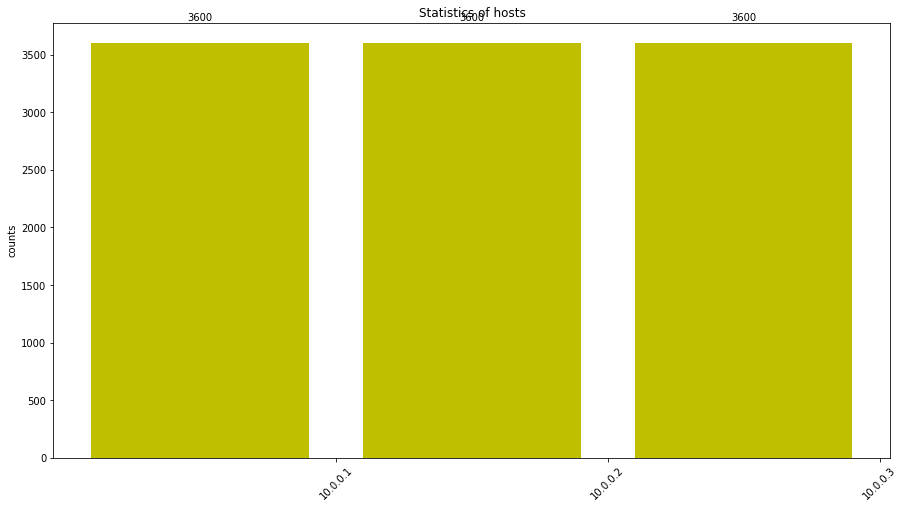

In [11]:
# plot simple bar chart
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

# query host IPs
print(handler.list_host_ips())
host_stats = handler.list_host_ips()
host_ips = []
counts = []
for stat in host_stats:
    host_ips.append(stat[0])
    counts.append(stat[1])

fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(len(host_ips))
rects = ax.bar(x, counts, color='y')
plt.xticks(x+0.5, host_ips, rotation=45) 

def autolabel(rects):
    # attach 'counts' labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects) # add label on bar
plt.ylabel('counts')
plt.title('Statistics of hosts')
plt.show()


** Challenge 2: ** Generate a bar chart to show total number of records per metric of host 10.0.0.1

In [7]:
# Speculate your anwser here

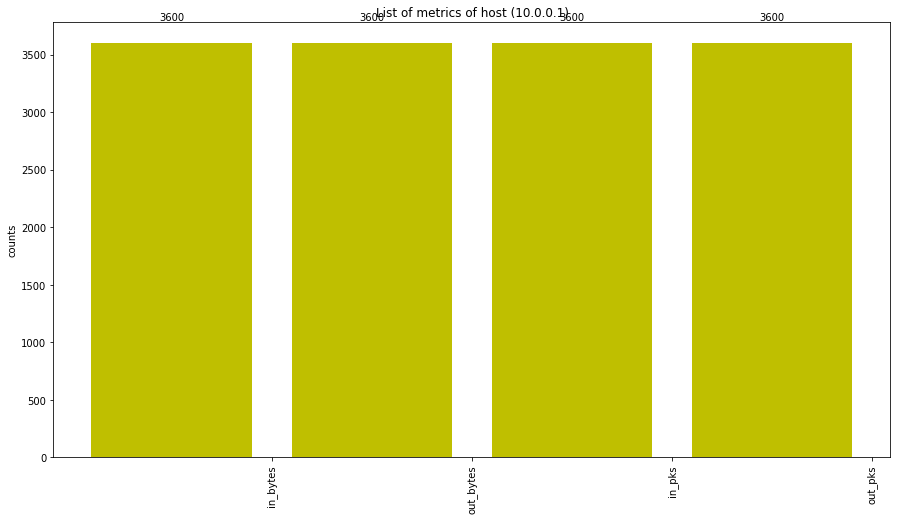

In [12]:
# plot simple bar chart
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# query metric lists
host_ip = "10.0.0.1"
filters = {"host_ips":[host_ip]}
metric_list = handler.list_metric_ids(filters=filters)

def autolabel(rects):
    # attach 'counts' labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

if len(metric_list) > 0:
    host_ip = metric_list[0][0]
    stats = metric_list[0][1]

    metric_ids=[]
    metric_counts=[]
    for stat in stats:
        metric_ids.append(stat[0])
        metric_counts.append(stat[1])
    x = np.arange(len(metric_ids))
    fig, ax = plt.subplots(figsize=(15, 8))
    metric_rects = ax.bar(x, metric_counts, color='y')
    plt.xticks(x+0.5, metric_ids, rotation='vertical')
    plt.ylabel ('counts')
    plt.title('List of metrics of host (%s)' % host_ip)
    autolabel(metric_rects)
    plt.draw()

### Introducing interactive UI ###
Interactivity introduction to your notebook can be done by adding widgets provided in the `ipywidgets` package. Each widget consists of two parts: the UI element (e.g. Text Input, sliding bar, etc.) and an event handler. 

** Example 5: ** Interactive visualization of total number of records per metric of a particular host

In [15]:
%matplotlib inline
from ipywidgets import *
from IPython.display import display
import matplotlib.patches as mpatches

options= ['--select--'] + sorted(host_ips)
selected_host = "--select--"

host_ip_widget = widgets.Dropdown(description='Host IP:', width=100, options=options)
display(host_ip_widget)
# diplaying the limits input widget:
limits_input = widgets.Text(description="limits :", width=200)
display(limits_input)
# preparing a container to put in the created checkbox per host ip
checkboxes = []
cb_container=widgets.HBox()
display(cb_container)

# add button that updates the graph based on the checkboxes
button = widgets.Button(description="submit")
display(button)

def on_button_clicked(b):
    selected_host = host_ip_widget.value
    
    def autolabel(rects):
        # attach 'counts' labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')
    limit = -1
    if limits_input.value:
        limit = int(limits_input.value)
        
    filters={}
    metrics = None
    if selected_host != "--select--":
        filters['host_ips']=[selected_host] 
        metrics = handler.list_metric_ids(limit=limit, filters=filters)
        if len(metrics) > 0:
            host_ip = metrics[0][0]
            metric_stats = metrics[0][1]

            metric_ids=[]
            metric_counts=[]
            for stat in metric_stats:
                metric_ids.append(stat[0])
                metric_counts.append(stat[1])
            x = np.arange(len(metric_ids))
            fig, ax = plt.subplots(figsize=(15, 8))
            metric_rects = ax.bar(x, metric_counts, color='y')
            plt.xticks(x+0.5, metric_ids, rotation='vertical') 
            plt.ylabel ('counts')
            patch = mpatches.Patch(color='y', label=host_ip)
            plt.legend(handles=[patch])
            autolabel(metric_rects)
            plt.draw()
    else:
        print("Please select a host ip from dropdown list.")
        
button.on_click(on_button_clicked)



Dropdown(description='Host IP:', options=('--select--', '10.0.0.1', '10.0.0.2', '10.0.0.3'), value='--select--…

Text(value='', description='limits :')

HBox()

Button(description='submit', style=ButtonStyle())

** Example 6: ** Interactive time series visualization

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from ipywidgets import *
from operator import add
from IPython.display import display
import calendar
import time

dateFormatString = '%Y-%m-%d %H:%M:%S'

colors=['b', 'c', 'y', 'm', 'r']

# displaying the metric id input widget
metric_id_input = widgets.Text(description="metric id:", width=200)
display(metric_id_input)

host_ip_input = widgets.Text(description="host ip:", width=200, value='edit and hit to add')
display(host_ip_input)

#preparing the plot 
plots = dict()  

#preparing a container to put in created checkbox per host ip
checkboxes = []  
cb_container = widgets.HBox()  
display(cb_container)

#preparing update button
update_button = widgets.Button(description="Update")

#normalise data with 5-min interval
def post_process(data):
    def f(x): 
        sum_val = 0
        for val in x:
            sum_val = sum_val + x[0][1]
        return sum_val
    data_rdd = sc.parallelize(data).map(lambda x: (x[0], int(x[1]))).foldByKey(0, add).sortBy(lambda x: x[0]).groupBy(lambda x : (calendar.timegm(time.strptime(datetime.datetime.fromtimestamp(x[0]/1000).strftime('%Y-%m-%d %H:%M:%S'), dateFormatString))/(5*60))).map(lambda x : (x[0],list(x[1]))).mapValues(f).map(lambda x: (datetime.datetime.fromtimestamp(x[0] * 6*50), x[1]))
    return data_rdd.keys().collect(), data_rdd.values().collect()

#function to deal with the added host ip
def handle_submit(sender):  
    exists = False
    for cb in checkboxes:
        if cb.description is host_ip_input.value:
            exists = True
    if not exists and len(checkboxes)<5:
        #add a new checkbox for the new host ip
        checkboxes.append(widgets.Checkbox(description = host_ip_input.value, value=True, width=90))
        cb_container.children=[i for i in checkboxes]
        if len(checkboxes) == 1:
            display(update_button)

#function to deal with the checkbox update button       
def on_button_clicked(b): 
    filters = {}
    filters['metrics']=[metric_id_input.value]
    host_ips = []
    for c in cb_container.children:
        if c.value:
            host_ips.append(c.description)            
    filters['host_ips'] = host_ips

    results = handler.execute_query(filters=filters)

    i=0
    if len(results) > 0:
        # Plot things...
        fig = plt.figure(figsize=(15, 8))
        ax=fig.add_subplot(111)
        for result in results:
            label = result[0][1]
            timestamps, values = post_process(result[1])
            ax.plot_date(timestamps, values, c=colors[i], label=label)
            i=i+1
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
        plt.ylabel(metric_id_input.value)
        plt.xlabel("time of the day")
        plt.legend(loc='upper right')
        plt.gray()    
        plt.show()
        
update_button.on_click(on_button_clicked)  
host_ip_input.on_submit(handle_submit)  


Text(value='', description='metric id:')

Text(value='edit and hit to add', description='host ip:')

HBox()

** Challenge 3: ** generate scatter plots to show packet/bytes drops (e.g. use in_byte metric) of a partiular host

In [ ]:
# Speculate your anwser here

Text(value='', description='Host IP:')

Text(value='edit and hit to add', description='metric:')

HBox()

Button(description='Update', style=ButtonStyle())

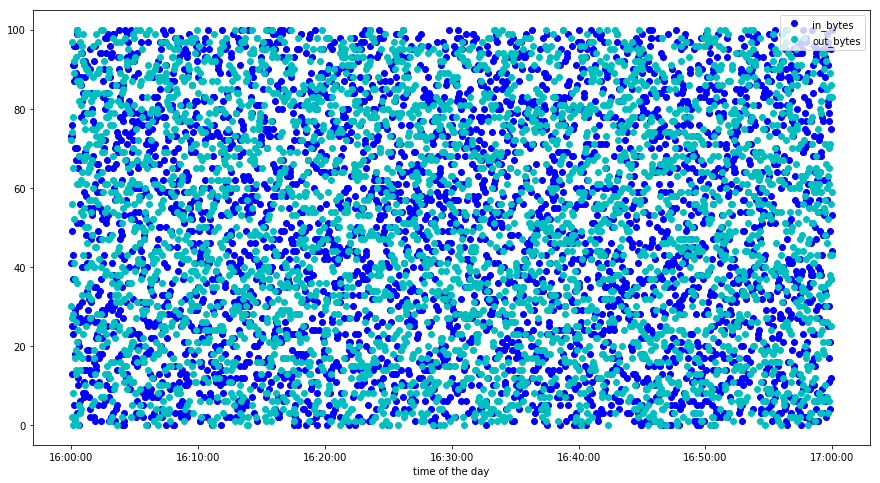

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from ipywidgets import *
from operator import add
from IPython.display import display
import calendar
import time

dateFormatString = '%Y-%m-%d %H:%M:%S'

colors=['b', 'c', 'y', 'm', 'r']

# displaying the metric id input widget
# metric_id_input = widgets.Text(description="metric id:", width=200)
host_ip_input = widgets.Text(description="Host IP:", width=200)
display(host_ip_input)

metric_input = widgets.Text(description="metric:", width=200, value='edit and hit to add')
display(metric_input)

#preparing the plot
plots = dict()

#preparing a container to put in created checkbox per host ip
checkboxes = []
cb_container = widgets.HBox()
display(cb_container)

#preparing update button
update_button = widgets.Button(description="Update")

#normalise data with 5-min interval
def post_process(data):
    def f(x):
        sum_val = 0
        for val in x:
            sum_val = sum_val + x[0][1]
        return sum_val
    data_rdd = sc.parallelize(data).map(lambda x: (x[0], int(x[1]))).foldByKey(0, add).sortBy(lambda x: x[0]).groupBy(lambda x : (calendar.timegm(time.strptime(datetime.datetime.fromtimestamp(x[0]/1000).strftime('%Y-%m-%d %H:%M:%S'), dateFormatString))/(5*60))).map(lambda x : (x[0],list(x[1]))).mapValues(f).map(lambda x: (datetime.datetime.fromtimestamp(x[0] * 6*50), x[1]))
    return data_rdd.keys().collect(), data_rdd.values().collect()

#function to deal with the added host ip
def handle_submit(sender):
    exists = False
    for cb in checkboxes:
        if cb.description is metric_input.value:
            exists = True
    if not exists and len(checkboxes)<5:
        #add a new checkbox for the new host ip
        checkboxes.append(widgets.Checkbox(description = metric_input.value, value=True, width=90))
        cb_container.children=[i for i in checkboxes]
        if len(checkboxes) == 1:
            display(update_button)

#function to deal with the checkbox update button
def on_button_clicked(b):
    filters = {}
    filters['host_ips']=[host_ip_input.value]

    metric_ids = []
    for c in cb_container.children:
        if c.value:
            metric_ids.append(c.description)
    filters['metrics'] = metric_ids

    results = handler.execute_query(filters=filters)

    i=0
    if len(results) > 0:
        # Plot things...
        fig = plt.figure(figsize=(15, 8))
        ax=fig.add_subplot(111)
        for result in results:
            label = result[0][0]
            timestamps, values = post_process(result[1])
            ax.plot_date(timestamps, values, c=colors[i], label=label)
            i=i+1
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"))
        plt.xlabel("time of the day")
        plt.legend(loc='upper right')
        plt.gray()
        plt.show()

update_button.on_click(on_button_clicked)
metric_input.on_submit(handle_submit)